<a href="https://colab.research.google.com/github/Naldershof/Wikigraphs/blob/main/WikiLinksStarting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:  
  import wikipedia
except:
  !pip install wikipedia
  import wikipedia

try:
  import umap
  import umap.plot
except:
  !pip install umap-learn
  !pip install umap-learn[plot]
  import umap
  import umap.plot

try:
  import plotly.express as px
except:
  !pip install plotly
  import plotly.express as px

import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# TODO TOMORROW
# Filter by pageviews instead
# Can get page views from sample GCP project, should be good enough even if the rest of this isn't super fast. 

In [ ]:
#https://wikipedia.readthedocs.io/en/latest/code.html#api
Philosophy = wikipedia.page("Philosophy")

In [ ]:
%%time
# 1000 may be too many, 100 takes like 40 seconds, so should take around 5 min 
# Fuck it, let's go crazy, 5000, thirty minutes or whatever, I'll go ddo something else for a bit
max_links = min(5000, len(Philosophy.links))
print(max_links)

# So while we're dealing with getting those file uploads, 
# lets just try selecting a random 100 of the links from philosophy
# getting the links between them, and then creating a graph off that 
# will let us start getting things moving

# Yeah this is not very performant... We're probably gonna have to just
# use the actual stuff.   
link_dict = {}
all_links = []

random_links = np.random.choice(Philosophy.links, max_links, replace=False)

# Record things that we don't have and remove them from all our lists
missing_pages = []

for link in random_links:
  try:
    page = wikipedia.page(link)
    page_links = page.links
    # Thissss is going to get real nasty when I remove the intersection shit, GET READY FOR SOME NONSENSE 
    #link_dict[link] = list(set(random_links).intersection(page_links))
    # Yeah I should do the direction 2 thing but that's a fuckload of data... I might have to just give up and actually use the real data...
    link_dict[link] = page_links
    all_links.extend(page_links)
  except:
    missing_pages.append(link)

1245


/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning:

No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.




CPU times: user 1min 14s, sys: 4.53 s, total: 1min 18s
Wall time: 12min 33s


In [ ]:
# And next, come back and get links from all the new pages to pages in the original dataset, should basically make it so that we have 
# links of degree 2 from the original page, could be better, but not bad at all. 
# Nah, that's too many, but what if instead we trim this down to only links which are seen at least twice? five times? Lets see how many. 
from collections import Counter
df = pd.DataFrame.from_dict(Counter(all_links), orient='index').reset_index()
df.columns = ['title', 'counts']
print("Limiting to above {}".format(df.counts.quantile(0.975)))
lim_df = df[df.counts >= df.counts.quantile(0.975)]
print(lim_df.shape)

Limiting to above 28.0
(3589, 2)


In [ ]:
new_pages = list(lim_df['title'])
actually_new_pages = [x for x in new_pages if x not in random_links]
len(actually_new_pages)

2605

In [ ]:
%%time
for link in actually_new_pages:
  try:
    page = wikipedia.page(link)
    page_links = page.links
    # Thissss is going to get real nasty when I remove the intersection shit, GET READY FOR SOME NONSENSE 
    #link_dict[link] = list(set(random_links).intersection(page_links))
    # Yeah I should do the direction 2 thing but that's a fuckload of data... I might have to just give up and actually use the real data...
    link_dict[link] = page_links
    all_links.extend(page_links)
  except:
    #missing_pages.append(link)
    pass

/usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py:389: UserWarning:

No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.7/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.




CPU times: user 2min 36s, sys: 9.76 s, total: 2min 46s
Wall time: 25min 59s


In [ ]:
for missing in missing_pages:
  # Yeah, this is nonsense, fix it, I think instead just prune isolates should take care of it
  # This code be way better but I'm lazy rn
  try:
    del(link_dict[missing])
  except:
    pass

In [ ]:
G = nx.from_dict_of_lists(link_dict, nx.DiGraph)
#G = nx.from_dict_of_lists(link_dict, nx.Graph)
G.remove_nodes_from(list(nx.isolates(G)))

In [ ]:
# Ok so remove nodes that are not in the union of actually_new_pages and random_links
nodes_of_importance = list(list(random_links) + list(actually_new_pages))
subgraph = G.subgraph(nodes_of_importance)

In [ ]:
# Can start from here if the data is already created
subgraph.in_degree

InDegreeView({'European Union': 104, 'History of philosophy': 60, 'Australian Aboriginal religion and mythology': 272, 'Peter Lombard': 141, 'Onesicritus': 94, 'Anupalabdhi': 154, 'Geshe': 395, 'Adrishta': 154, 'William Wollaston': 179, 'Muhammad Iqbal': 75, 'Descartes': 86, 'Avicennism': 288, 'Haymanot': 225, 'Robert C. Solomon': 16, 'Water and religion': 205, 'Telecles': 139, 'Sharia': 119, 'Cyrenaics': 393, 'South Africa': 102, 'Jewish Renewal': 241, 'Family of Gautama Buddha': 394, 'Values education': 59, 'Diogenes of Babylon': 96, 'Hasidic Judaism': 241, 'Criminology': 78, 'Maximus of Ephesus': 139, 'Self-fulfilling prophecy': 72, 'Platonism': 563, 'Sosipatra': 139, 'Assaji': 393, 'Creator in Buddhism': 613, 'Religious naturalism': 207, 'Cryptomnesia': 58, 'Explanatory power': 173, 'Observational error': 57, 'Zhuang Zhou': 138, 'Science and technology studies': 76, 'Wilhelm Dilthey': 147, 'Ordinary language philosophy': 337, 'Hermias (philosopher)': 139, 'Arhat': 419, 'Samatha': 4

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
#nx.readwrite.gpickle.write_gpickle(G, 'test.pkl')
try: 
  #nx.readwrite.gpickle.write_gpickle(subgraph, '/content/gdrive/MyDrive/digraphtest_.pkl')
  #nx.readwrite.write_adjlist(subgraph, '/content/gdrive/MyDrive/test.adjlist', delimiter='####')
  nx.readwrite.gexf.write_gexf(subgraph, '/content/gdrive/MyDrive/test.gexf')
except:
  #subgraph = nx.readwrite.gpickle.read_gpickle('/content/gdrive/MyDrive/digraphtest.pkl')
  pass

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
subgraph = nx.readwrite.gexf.read_gexf('/content/gdrive/MyDrive/test.gexf')

In [ ]:
subgraph

In [ ]:
adjacency = nx.linalg.graphmatrix.adjacency_matrix(subgraph)
print(adjacency.shape)

(3850, 3850)


In [ ]:
%%time
mapper = umap.UMAP(metric='cosine', random_state=42, 
                   low_memory=False, n_neighbors=20).fit(adjacency)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:

The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:126: UserWarning:

A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 3338200 edges.
It has only fully disconnected 252 vertices.
Use umap.utils.disconnected_vertices() to identify them.



CPU times: user 23.5 s, sys: 414 ms, total: 23.9 s
Wall time: 22.8 s


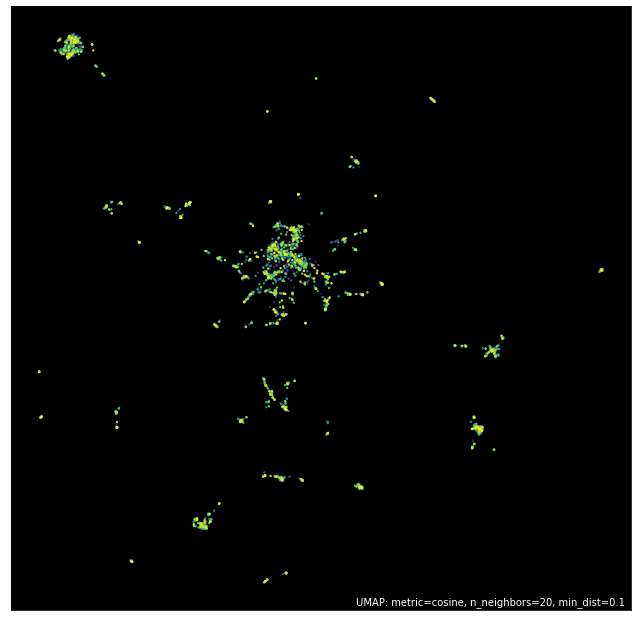

In [ ]:
umap.plot.points(mapper, values=np.arange(adjacency.shape[0]), theme='viridis')

In [ ]:
proj_2d = mapper.fit_transform(adjacency)

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:126: UserWarning:

A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 3338200 edges.
It has only fully disconnected 252 vertices.
Use umap.utils.disconnected_vertices() to identify them.



In [ ]:
len(list(nx.nodes(subgraph)))

3850

In [ ]:
"""fig_2d = px.scatter(
    proj_2d, x=0, y=1, text=list(nx.nodes(G))    
)"""

fig_2d = px.scatter(
    proj_2d, x=0, y=1, hover_name=list(nx.nodes(subgraph))    
)

fig_2d.show()
fig_2d.write_html("test_concepts_directed.html")

In [ ]:
#Ok now add pagerank
pr = nx.algorithms.link_analysis.pagerank_alg.pagerank(subgraph)

In [ ]:
df = pd.DataFrame.from_dict(pr, orient='index').reset_index()
df.columns = ['name', 'importance']

In [ ]:
df.sort_values('importance', ascending=False).head(100)

,name,importance
236,ISBN (identifier),0.017822
3383,Doi (identifier),0.013175
1358,Pinyin,0.006775
3253,PMID (identifier),0.006703
1168,S2CID (identifier),0.006522
...,...,...
2889,Hebrew language,0.000698
214,Traditional Chinese characters,0.000693
1189,Wade–Giles,0.000689
1442,The Guardian,0.000678


In [ ]:
t# Will need to get the pageviews for some of this so I can limit the
# links and make some nice little things
# Example here of getting this into google clcoud
# https://codelabs.developers.google.com/codelabs/cloud-bigquery-wikipedia#4

# Ehh, just save to drive, these are pretty small (like 500mb each)
# https://dumps.wikimedia.org/other/pageview_complete/readme.html
# All 8/2021 is only 2.5gb, not the end of the world
# https://dumps.wikimedia.org/other/pageview_complete/monthly/2021/2021-08/

In [ ]:
#Basically I want to play with knowledge graphs cause they're fun